In [1]:
# append parent to path to allow imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

In [2]:
from pathlib import Path
import cv2
import numpy as np

from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.superpixels import SuperpixelExtractor
from src.feature import Feature, FeatureExtractor, FeatureDivergence

In [3]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path('test_images/face.jpg')

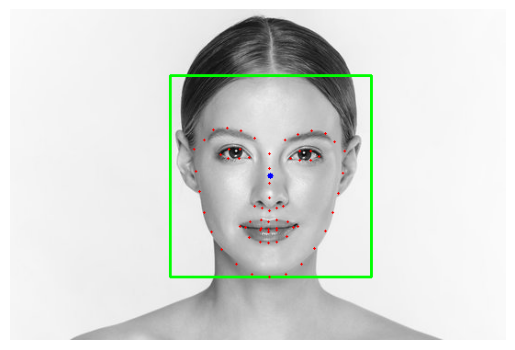

In [4]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH, display_indices=False)
Utils.display(img_rgb)

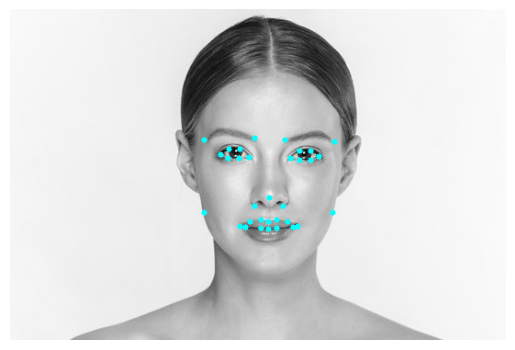

1


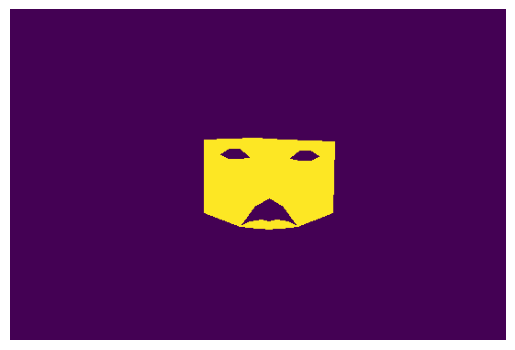

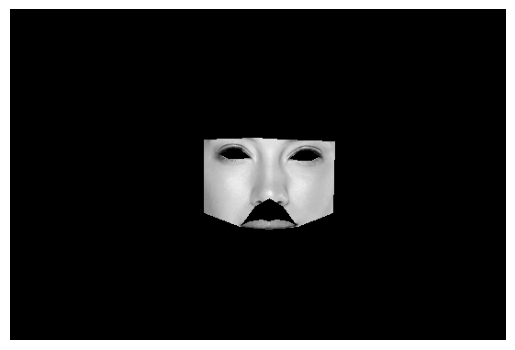

In [5]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts)
print(len(masks))
Utils.display(masks[0])
Utils.display(masked_imgs[0])

1


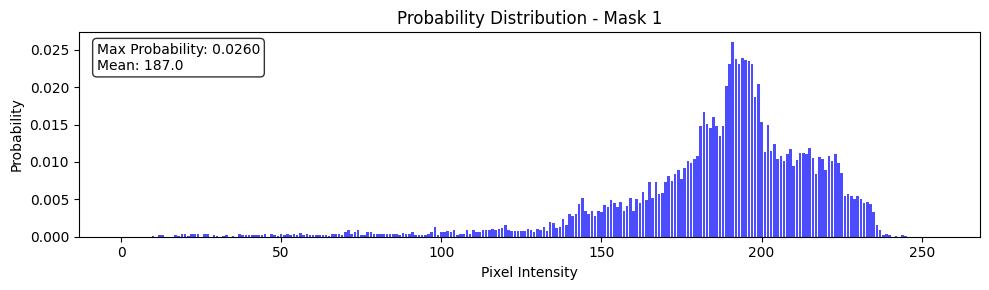

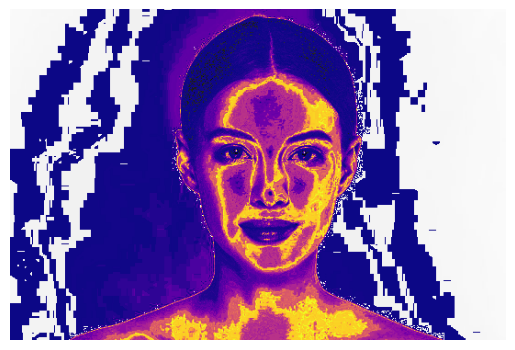

In [6]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

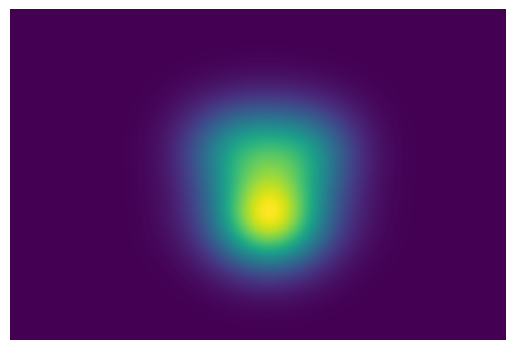

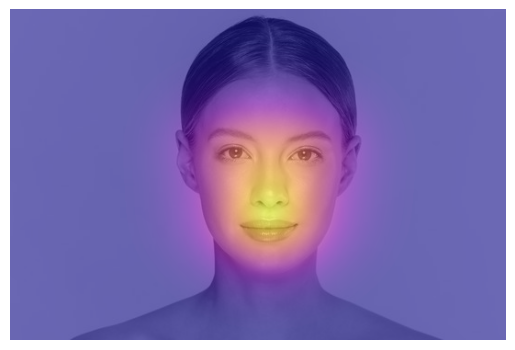

In [7]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(IMAGE_PATH, selected_pts)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

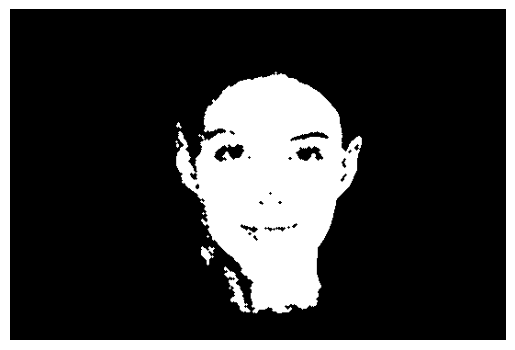

In [8]:
alpha = 0.8851773188792857
lambda_ = 0.0006174988170846915
skin_pixel_maps = mh.get_skin_pixel_maps(IMAGE_PATH, intensity_histograms, prior_face_masks, alpha, lambda_)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

idx = 0
Utils.display(skin_pixel_maps[idx], cmap="gray")

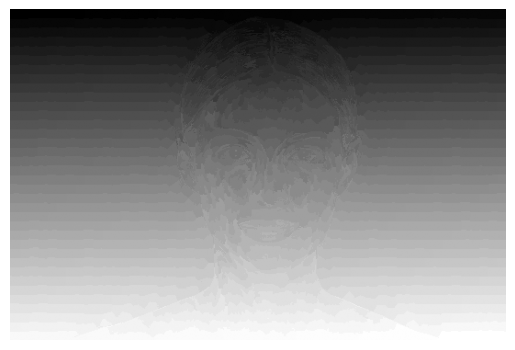

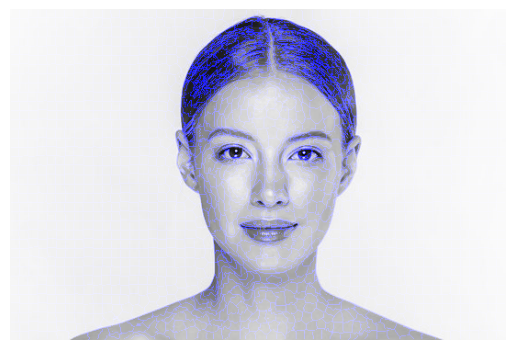

In [10]:
Utils.display(labels, cmap="gray")
Utils.display(contoured_img)

In [11]:
feature_vectors_sp = fe.extract_all_features_superpixels(IMAGE_PATH, slic)
print(feature_vectors_sp)

[Feature(label=0, mean_intensity=np.float64(249.19834710743802), std_intensity=np.float64(0.39875497791123365), entropy=np.float64(0.3388823317671177), lacunarity_vector=array([1.        , 0.96694215, 0.23966942, 0.85123967, 1.        ,
       0.47107438, 1.        , 1.        , 1.        , 0.23966942,
       0.85123967, 1.        , 1.        , 0.47107438, 0.91735537,
       0.38016529, 1.        , 1.        , 0.84297521, 0.70247934,
       1.        , 1.        , 0.96694215, 0.9338843 , 0.38016529,
       0.80165289, 0.96694215, 0.59504132, 0.96694215, 1.        ,
       1.        , 0.38016529, 0.80165289, 0.97520661, 0.88429752,
       0.59504132, 0.82644628, 0.47107438, 1.        , 1.        ,
       0.7768595 , 0.8677686 , 1.        , 1.        ])), Feature(label=1, mean_intensity=np.float64(249.0), std_intensity=np.float64(0.0), entropy=np.float64(0.05354938088195042), lacunarity_vector=array([1.        , 1.        , 0.11009174, 1.        , 1.        ,
       0.34862385, 1.       

In [13]:
len(feature_vectors_sp)

1944